# Hypothesis - Device Activity

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample

**Read Data**

In [2]:
# import data
data = pd.read_csv('../data/raw/raw_data.csv')
print(f"data shape: {data.shape}")
data.head()

data shape: (1000000, 32)


fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           0     0.3               0.986506                         -1   
1           0     0.8               0.617426                         -1   
2           0     0.8               0.996707                          9   
3           0     0.6               0.475100                         11   
4           0     0.9               0.842307                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            25            40            0.006735   
1                            89            20            0.010095   
2                            14            40            0.012316   
3                            14            30            0.006991   
4                            29            40            5.742626   

   intended_balcon_amount payment_type  zip_count_4w  ...  has_other_cards  \
0              102.453711           AA          1059  ...                0   
1               -0.849551           AD          1658  ...                0   
2               -1.490386           AB          1095  ...                0   
3               -1.863101           AB          3483  ...                0   
4               47.152498           AA          2339  ...                0   

   proposed_credit_limit  foreign_request    source  \
0                 1500.0                0  INTERNET   
1                 1500.0                0  INTERNET   
2                  200.0                0  INTERNET   
3                  200.0                0  INTERNET   
4                  200.0                0  INTERNET   

   session_length_in_minutes device_os  keep_alive_session  \
0                  16.224843     linux                   1   
1                   3.363854     other                   1   
2                  22.730559   windows                   0   
3                  15.215816     linux                   1   
4                   3.743048     other                   0   

   device_distinct_emails_8w device_fraud_count  month  
0                          1                  0      0  
1                          1                  0      0  
2                          1                  0      0  
3                          1                  0      0  
4                          1                  0      0  

[5 rows x 32 columns]

## Data Cleaning + Undersampling

1. Followed 1.0-data-preprocessing.ipynb

In [3]:
# Data Cleaning
data['intended_balcon_amount'] = data['intended_balcon_amount'].apply(lambda x: -1 if x < 0 else x)
data = data[(data['current_address_months_count'] >= 0) & (data['session_length_in_minutes'] >= 0) & (data['device_distinct_emails_8w'] >= 0)]

# Convert the variables to the appropriate data types
data['fraud_bool'] = data['fraud_bool'].astype('category')
data['payment_type'] = data['payment_type'].astype('category')
data['employment_status'] = data['employment_status'].astype('category')
data['email_is_free'] = data['email_is_free'].astype('uint8')
data['housing_status'] = data['housing_status'].astype('category')
data['phone_home_valid'] = data['phone_home_valid'].astype('uint8')
data['phone_mobile_valid'] = data['phone_mobile_valid'].astype('uint8')
data['has_other_cards'] = data['has_other_cards'].astype('uint8')
data['foreign_request'] = data['foreign_request'].astype('uint8')
data['source'] = data['source'].astype('category')
data['device_os'] = data['device_os'].astype('category')

# Remove Redundant rows
data.drop(columns=['device_fraud_count'], inplace=True)

# Ratio of 1 to 5
# Separate fraud and non-fraud data
fraud_data = data[data['fraud_bool'] == 1]
non_fraud_data = data[data['fraud_bool'] == 0]

# Undersample non-fraud data to match the size of the fraud data
undersampled_non_fraud_data = resample(non_fraud_data, replace=False, n_samples=5*len(fraud_data), random_state=42)

# Combine fraud and undersampled non-fraud data
undersampled_data = pd.concat([fraud_data, undersampled_non_fraud_data])

data = undersampled_data

# check shape and head of data
print(f"data shape: {data.shape}")
data.head()

data shape: (65970, 31)


fraud_bool  income  name_email_similarity  prev_address_months_count  \
43           1     0.9               0.570800                         -1   
140          1     0.1               0.993219                         -1   
284          1     0.8               0.794351                         -1   
314          1     0.7               0.090000                         -1   
561          1     0.9               0.998248                         31   

     current_address_months_count  customer_age  days_since_request  \
43                            157            60            0.005908   
140                            67            20            0.015331   
284                           376            60           17.925951   
314                            58            50            0.004134   
561                            45            30            0.010165   

     intended_balcon_amount payment_type  zip_count_4w  ...  \
43                35.337538           AA          4079  ...   
140               92.120139           AA          1192  ...   
284               41.422110           AA           815  ...   
314               -1.000000           AD          4011  ...   
561               33.067538           AA           525  ...   

     bank_months_count  has_other_cards  proposed_credit_limit  \
43                  30                0                 1500.0   
140                 25                0                 1500.0   
284                 28                0                 1500.0   
314                 27                0                 1500.0   
561                  1                1                 2000.0   

     foreign_request    source session_length_in_minutes  device_os  \
43                 0  INTERNET                  4.036394    windows   
140                0  INTERNET                 12.928072    windows   
284                0  INTERNET                  2.550167      linux   
314                0  INTERNET                  3.500856    windows   
561                0  INTERNET                 44.536211    windows   

     keep_alive_session device_distinct_emails_8w  month  
43                    1                         1      0  
140                   0                         1      0  
284                   0                         1      0  
314                   0                         1      0  
561                   0                         1      0  

[5 rows x 31 columns]

## EDA Bank Activity and Device Activity

**Hypothesis: Fraudulent Bank Accounts have unique characteristics in relation to how their device activity.**
* More likely to use a phone that has more lax security i.e. windows
* More likely to have more than 1 email in each device. --> more emails to create more fake accounts
* If a phone has more than 1 email from each device, then it keep_alive_session likely to be false (i.e. value=0) --> convienience on fraudster's end. troublesome to log in and out continually.
* Session length will also be short??

**Columns considered**

* Device Activity:
    * `session_length_in_minutes`
    * `device_os`
    * `keep_alive_session`
    * `device_distinct_emails_8w`
    * `source`
    * `foreign_request`

* Bank Activity:
    * `zip_count_4w`
    * `velocity_6h`
    * `velocity_24h`
    * `velocity_4w`
    * `bank_branch_count_8w`
    * `date_of_birth_distinct_emails_4w`

**Explanation of Columns**

| Column Name | Description | Link to Fraud |
|:------------|:------------|:--------------|
| device_distinct_emails_8w | No. of distinct emails in banking website from the used device in last 8 weeks. <br> Simply put, if I use my email address to log into the banking website, <br> then I effectively used 1 distinct email address. <br>If I leave the phone unattended for 8 weeks, then this value becomes 0 due to inactivity for 8 weeks. | Spare phones are commonly used to prevent banking companies from tracking them. <br> Thus, able to explain the inactivity. When the phone is actually used, <br>the fraudsters are likely to use more than 2 distinct email address for 2 accounts using the same phone.


In [4]:
# select columns related to device activity
device_activity  = ['fraud_bool', 'session_length_in_minutes', 'device_os', 'keep_alive_session', 'device_distinct_emails_8w', 'source', 'foreign_request']
device_activity_df = data[device_activity]

# print shape
device_activity_df.shape
device_activity_df.head()

fraud_bool  session_length_in_minutes device_os  keep_alive_session  \
43           1                   4.036394   windows                   1   
140          1                  12.928072   windows                   0   
284          1                   2.550167     linux                   0   
314          1                   3.500856   windows                   0   
561          1                  44.536211   windows                   0   

     device_distinct_emails_8w    source  foreign_request  
43                           1  INTERNET                0  
140                          1  INTERNET                0  
284                          1  INTERNET                0  
314                          1  INTERNET                0  
561                          1  INTERNET                0

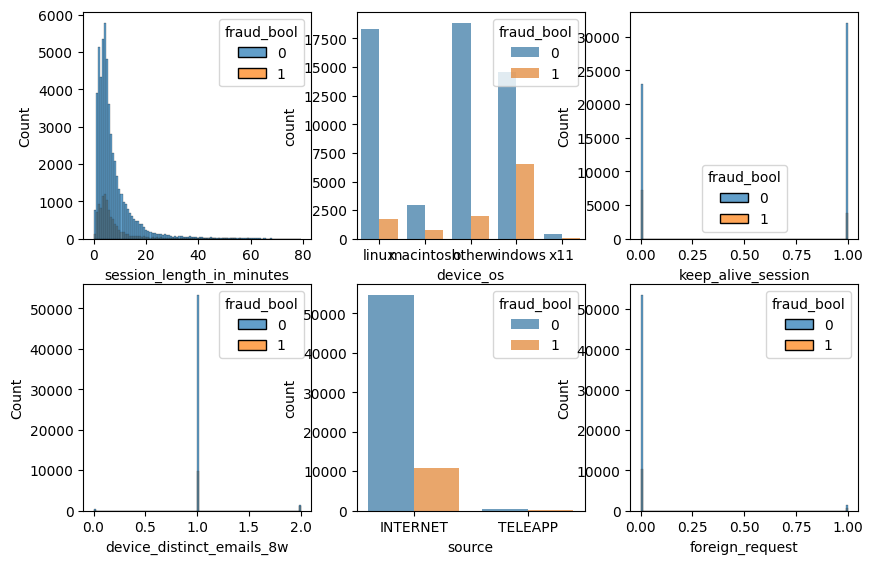

In [5]:
# for each column, if it is categorical, plot the value counts, if it is numerical, plot histogram
# put in a 3 x 3 grid, and color code the fraud_bool column
# print all except the first column
plt.figure(figsize=(10, 10))
for i, col in enumerate(device_activity_df.columns[1:]):
    plt.subplot(3, 3, i+1)
    if device_activity_df[col].dtype.name == 'category':
        sns.countplot(data=device_activity_df, x=col, hue='fraud_bool', alpha=0.7)
    else:
        sns.histplot(data=device_activity_df, x=col, hue='fraud_bool', bins=100, alpha=0.7)

/var/folders/_3/8z9s_23x6w349w1_9vlqlhzh0000gn/T/ipykernel_44844/1158177696.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  device_activity_df['device_distinct_emails_8w'] = device_activity_df['device_distinct_emails_8w'].astype('category')


                 column_name   category     fraud  non_fraud
0                  device_os    windows  0.308299   0.691701
0                  device_os      linux  0.085653   0.914347
0                  device_os      other  0.094239   0.905761
0                  device_os  macintosh  0.204076   0.795924
0                  device_os        x11  0.171247   0.828753
0         keep_alive_session          1  0.105193   0.894807
0         keep_alive_session          0  0.239448   0.760552
0                     source   INTERNET  0.166179   0.833821
0                     source    TELEAPP  0.248718   0.751282
0            foreign_request          0  0.163176   0.836824
0            foreign_request          1  0.278894   0.721106
0  device_distinct_emails_8w          1  0.155487   0.844513
0  device_distinct_emails_8w          2  0.433417   0.566583
0  device_distinct_emails_8w          0  0.331742   0.668258


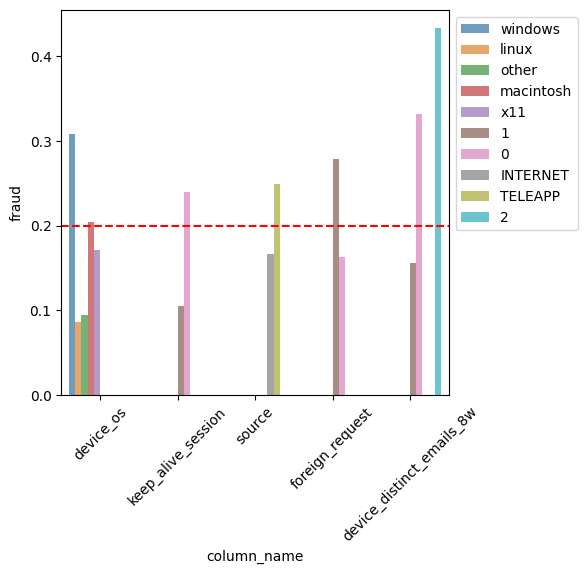

In [6]:
# chance device_distinct_emails_8w to category
device_activity_df['device_distinct_emails_8w'] = device_activity_df['device_distinct_emails_8w'].astype('category')

# check proportion of fraud vs non-fraud within each category
categorical_columns = ['fraud_bool', 'device_os', 'keep_alive_session', 'source', 'foreign_request', 'device_distinct_emails_8w']
device_activity_df_cat = device_activity_df[categorical_columns]

# caluclate proportion of fraud vs non-fraud for each category
# for each column, calculate the proportion of fraud vs non-fraud, store in dataframe
# there are 4 columns, 'column_name', 'category', 'fraud', 'non_fraud'
fraud_proportion = pd.DataFrame(columns=['column_name', 'category', 'fraud', 'non_fraud'])
for col in device_activity_df_cat.columns[1:]:
    for cat in device_activity_df_cat[col].unique():
        fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 1)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])
        non_fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 0)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])

        # add to dataframe using pd.concat to row
        fraud_proportion = pd.concat([fraud_proportion, pd.DataFrame({'column_name': [col], 'category': [cat], 'fraud': [fraud], 'non_fraud': [non_fraud]})])

# print table
print(fraud_proportion)

# a stacked barplot the proportion of fraud vs non-fraud for each category
# each column is labeled column_name + _ + category
# fraud is in red, non-fraud is in blue
# the y-axis is the proportion
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.barplot(data=fraud_proportion, x='column_name', y='fraud', hue='category', alpha=0.7)
plt.axhline(y=0.2, color='r', linestyle='--')
plt.xticks(rotation=45)
# legend is outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

### Feature 1: `device_distinct_emails` == 0 or 2 & `device_os` == windows --> featureEng01 == 1, else 0

<Axes: xlabel='featureEng01', ylabel='count'>

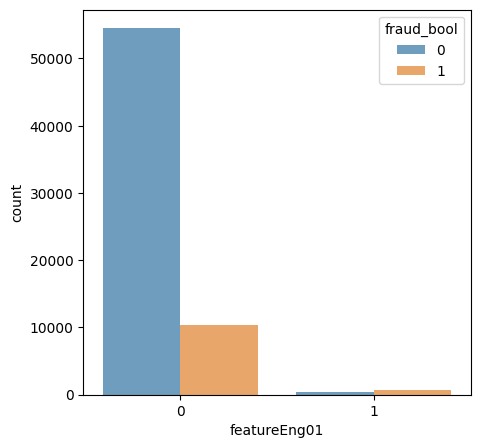

In [7]:
# label columns with the following conditions met as a new column, 'featureEng01'
# if conditions met, label as 1, else 0
# 1. device_os is 'windows'
# 2. device_distinct_emails_8w is 0 or 2
device_activity_df_cat['featureEng01'] = 0
device_activity_df_cat.loc[(device_activity_df_cat['device_os'] == 'windows') & (device_activity_df_cat['device_distinct_emails_8w'].isin([0, 2])), 'featureEng01'] = 1

# change 'featureEng01' to category
device_activity_df_cat['featureEng01'] = device_activity_df_cat['featureEng01'].astype('category')

# plot the proportion of fraud vs non-fraud for the new column 'featureEng01'
# fraud is in red, non-fraud is in blue
# y axis is the count
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.countplot(data=device_activity_df_cat, x='featureEng01', hue='fraud_bool', alpha=0.7)

                 column_name   category     fraud  non_fraud
0                  device_os    windows  0.308299   0.691701
0                  device_os      linux  0.085653   0.914347
0                  device_os      other  0.094239   0.905761
0                  device_os  macintosh  0.204076   0.795924
0                  device_os        x11  0.171247   0.828753
0         keep_alive_session          1  0.105193   0.894807
0         keep_alive_session          0  0.239448   0.760552
0                     source   INTERNET  0.166179   0.833821
0                     source    TELEAPP  0.248718   0.751282
0            foreign_request          0  0.163176   0.836824
0            foreign_request          1  0.278894   0.721106
0  device_distinct_emails_8w          1  0.155487   0.844513
0  device_distinct_emails_8w          2  0.433417   0.566583
0  device_distinct_emails_8w          0  0.331742   0.668258
0               featureEng01          0  0.158957   0.841043
0               featureE

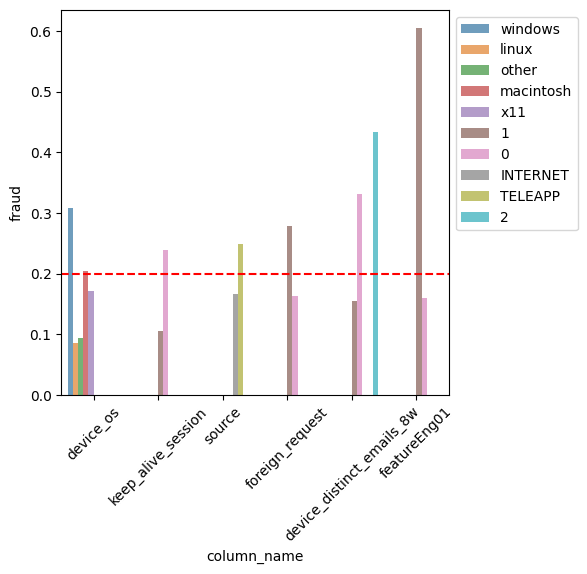

In [8]:
# reprint fraud proportion
# caluclate proportion of fraud vs non-fraud for each category
# for each column, calculate the proportion of fraud vs non-fraud, store in dataframe
# there are 4 columns, 'column_name', 'category', 'fraud', 'non_fraud'
fraud_proportion = pd.DataFrame(columns=['column_name', 'category', 'fraud', 'non_fraud'])
for col in device_activity_df_cat.columns[1:]:
    for cat in device_activity_df_cat[col].unique():
        fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 1)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])
        non_fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 0)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])

        # add to dataframe using pd.concat to row
        fraud_proportion = pd.concat([fraud_proportion, pd.DataFrame({'column_name': [col], 'category': [cat], 'fraud': [fraud], 'non_fraud': [non_fraud]})])

# print table
print(fraud_proportion)

# a stacked barplot the proportion of fraud vs non-fraud for each category
# each column is labeled column_name + _ + category
# fraud is in red, non-fraud is in blue
# the y-axis is the proportion
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.barplot(data=fraud_proportion, x='column_name', y='fraud', hue='category', alpha=0.7)
plt.axhline(y=0.2, color='r', linestyle='--')
plt.xticks(rotation=45)
# legend is outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

### Feature 2: `device_distinct_emails_8w` == 2 & `keep_alive_session` == 0, featureEng02 == 1, else 0

<Axes: xlabel='featureEng02', ylabel='count'>

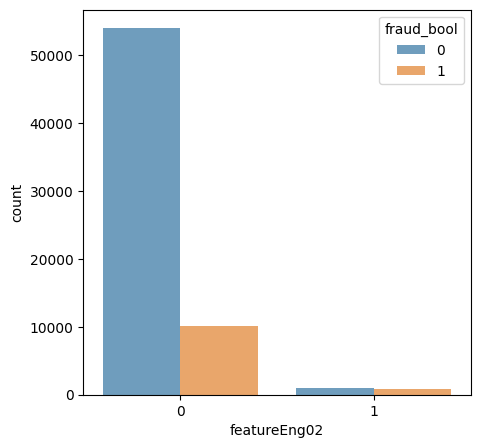

In [9]:
# label columns with the following conditions met as a new column, 'featureEng02'
# if conditions met, label as 1, else 0
# 1. device_distinct_emails_8w is 2
# 2. keep_alive_session is '0'
device_activity_df_cat['featureEng02'] = 0
device_activity_df_cat.loc[(device_activity_df_cat['device_distinct_emails_8w'] == 2) & (device_activity_df_cat['keep_alive_session'] == 0), 'featureEng02'] = 1

# change 'featureEng02' to category
device_activity_df_cat['featureEng02'] = device_activity_df_cat['featureEng02'].astype('category')

# plot the proportion of fraud vs non-fraud for the new column 'featureEng01'
# fraud is in red, non-fraud is in blue
# y axis is the count
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.countplot(data=device_activity_df_cat, x='featureEng02', hue='fraud_bool', alpha=0.7)

                 column_name   category     fraud  non_fraud
0                  device_os    windows  0.308299   0.691701
0                  device_os      linux  0.085653   0.914347
0                  device_os      other  0.094239   0.905761
0                  device_os  macintosh  0.204076   0.795924
0                  device_os        x11  0.171247   0.828753
0         keep_alive_session          1  0.105193   0.894807
0         keep_alive_session          0  0.239448   0.760552
0                     source   INTERNET  0.166179   0.833821
0                     source    TELEAPP  0.248718   0.751282
0            foreign_request          0  0.163176   0.836824
0            foreign_request          1  0.278894   0.721106
0  device_distinct_emails_8w          1  0.155487   0.844513
0  device_distinct_emails_8w          2  0.433417   0.566583
0  device_distinct_emails_8w          0  0.331742   0.668258
0               featureEng01          0  0.158957   0.841043
0               featureE

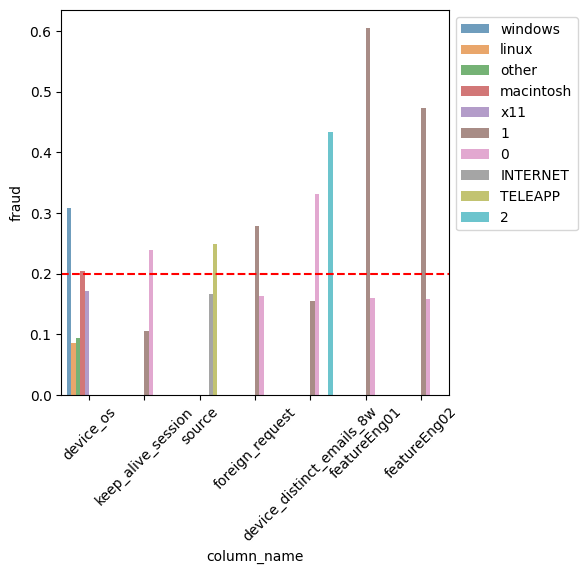

In [10]:
# reprint fraud proportion
# caluclate proportion of fraud vs non-fraud for each category
# for each column, calculate the proportion of fraud vs non-fraud, store in dataframe
# there are 4 columns, 'column_name', 'category', 'fraud', 'non_fraud'
fraud_proportion = pd.DataFrame(columns=['column_name', 'category', 'fraud', 'non_fraud'])
for col in device_activity_df_cat.columns[1:]:
    for cat in device_activity_df_cat[col].unique():
        fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 1)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])
        non_fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 0)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])

        # add to dataframe using pd.concat to row
        fraud_proportion = pd.concat([fraud_proportion, pd.DataFrame({'column_name': [col], 'category': [cat], 'fraud': [fraud], 'non_fraud': [non_fraud]})])

# print table
print(fraud_proportion)

# a stacked barplot the proportion of fraud vs non-fraud for each category
# each column is labeled column_name + _ + category
# fraud is in red, non-fraud is in blue
# the y-axis is the proportion
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.barplot(data=fraud_proportion, x='column_name', y='fraud', hue='category', alpha=0.7)
plt.axhline(y=0.2, color='r', linestyle='--')
plt.xticks(rotation=45)
# legend is outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

### Feature 3: `device_distinct_emails_8w` == 0/2 & `keep_alive_session` == 0 --> featureEng03 == 1, else 0

<Axes: xlabel='featureEng03', ylabel='count'>

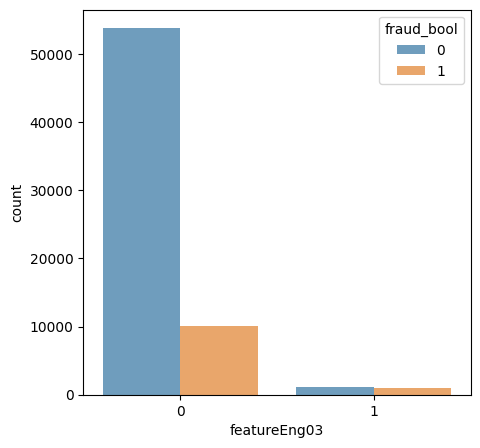

In [11]:
# label columns with the following conditions met as a new column, 'featureEng02'
# if conditions met, label as 1, else 0
# 1. device_distinct_emails_8w is 2
# 2. keep_alive_session is '0'
device_activity_df_cat['featureEng03'] = 0
device_activity_df_cat.loc[(device_activity_df_cat['device_distinct_emails_8w'].isin([0, 2])) & (device_activity_df_cat['keep_alive_session'] == 0), 'featureEng03'] = 1

# change 'featureEng02' to category
device_activity_df_cat['featureEng03'] = device_activity_df_cat['featureEng03'].astype('category')

# plot the proportion of fraud vs non-fraud for the new column 'featureEng01'
# fraud is in red, non-fraud is in blue
# y axis is the count
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.countplot(data=device_activity_df_cat, x='featureEng03', hue='fraud_bool', alpha=0.7)

                 column_name   category     fraud  non_fraud
0                  device_os    windows  0.308299   0.691701
0                  device_os      linux  0.085653   0.914347
0                  device_os      other  0.094239   0.905761
0                  device_os  macintosh  0.204076   0.795924
0                  device_os        x11  0.171247   0.828753
0         keep_alive_session          1  0.105193   0.894807
0         keep_alive_session          0  0.239448   0.760552
0                     source   INTERNET  0.166179   0.833821
0                     source    TELEAPP  0.248718   0.751282
0            foreign_request          0  0.163176   0.836824
0            foreign_request          1  0.278894   0.721106
0  device_distinct_emails_8w          1  0.155487   0.844513
0  device_distinct_emails_8w          2  0.433417   0.566583
0  device_distinct_emails_8w          0  0.331742   0.668258
0               featureEng01          0  0.158957   0.841043
0               featureE

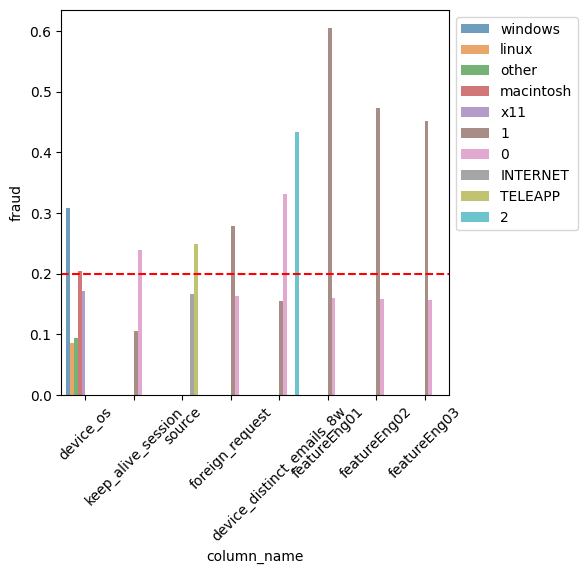

In [12]:
# reprint fraud proportion
# caluclate proportion of fraud vs non-fraud for each category
# for each column, calculate the proportion of fraud vs non-fraud, store in dataframe
# there are 4 columns, 'column_name', 'category', 'fraud', 'non_fraud'
fraud_proportion = pd.DataFrame(columns=['column_name', 'category', 'fraud', 'non_fraud'])
for col in device_activity_df_cat.columns[1:]:
    for cat in device_activity_df_cat[col].unique():
        fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 1)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])
        non_fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 0)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])

        # add to dataframe using pd.concat to row
        fraud_proportion = pd.concat([fraud_proportion, pd.DataFrame({'column_name': [col], 'category': [cat], 'fraud': [fraud], 'non_fraud': [non_fraud]})])

# print table
print(fraud_proportion)

# a stacked barplot the proportion of fraud vs non-fraud for each category
# each column is labeled column_name + _ + category
# fraud is in red, non-fraud is in blue
# the y-axis is the proportion
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.barplot(data=fraud_proportion, x='column_name', y='fraud', hue='category', alpha=0.7)
plt.axhline(y=0.2, color='r', linestyle='--')
plt.xticks(rotation=45)
# legend is outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

### Feature 4: `foreign_request` == 1 & `source` == INTERNET, then featureEng04 = 1, else 0

In [13]:
print(device_activity_df_cat[['featureEng01']].value_counts())
print(device_activity_df_cat[['featureEng02']].value_counts())
print(device_activity_df_cat[['featureEng03']].value_counts())

featureEng01
0               64829
1                1141
Name: count, dtype: int64
featureEng02
0               64176
1                1794
Name: count, dtype: int64
featureEng03
0               63801
1                2169
Name: count, dtype: int64


<Axes: xlabel='featureEng04', ylabel='count'>

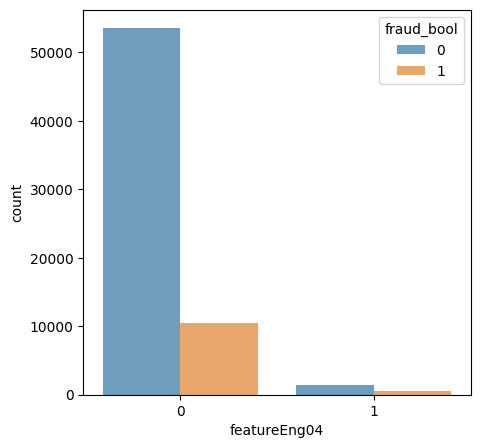

In [15]:
# label columns with the following conditions met as a new column, 'featureEng02'
# if conditions met, label as 1, else 0
# 1. device_distinct_emails_8w is 2
# 2. keep_alive_session is '0'
device_activity_df_cat['featureEng04'] = 0
device_activity_df_cat.loc[(device_activity_df_cat['foreign_request'] == 1) & (device_activity_df_cat['source'] == 'INTERNET'), 'featureEng04'] = 1

# change 'featureEng02' to category
device_activity_df_cat['featureEng04'] = device_activity_df_cat['featureEng04'].astype('category')

# plot the proportion of fraud vs non-fraud for the new column 'featureEng01'
# fraud is in red, non-fraud is in blue
# y axis is the count
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.countplot(data=device_activity_df_cat, x='featureEng04', hue='fraud_bool', alpha=0.7)

                 column_name   category     fraud  non_fraud
0                  device_os    windows  0.308299   0.691701
0                  device_os      linux  0.085653   0.914347
0                  device_os      other  0.094239   0.905761
0                  device_os  macintosh  0.204076   0.795924
0                  device_os        x11  0.171247   0.828753
0         keep_alive_session          1  0.105193   0.894807
0         keep_alive_session          0  0.239448   0.760552
0                     source   INTERNET  0.166179   0.833821
0                     source    TELEAPP  0.248718   0.751282
0            foreign_request          0  0.163176   0.836824
0            foreign_request          1  0.278894   0.721106
0  device_distinct_emails_8w          1  0.155487   0.844513
0  device_distinct_emails_8w          2  0.433417   0.566583
0  device_distinct_emails_8w          0  0.331742   0.668258
0               featureEng01          0  0.158957   0.841043
0               featureE

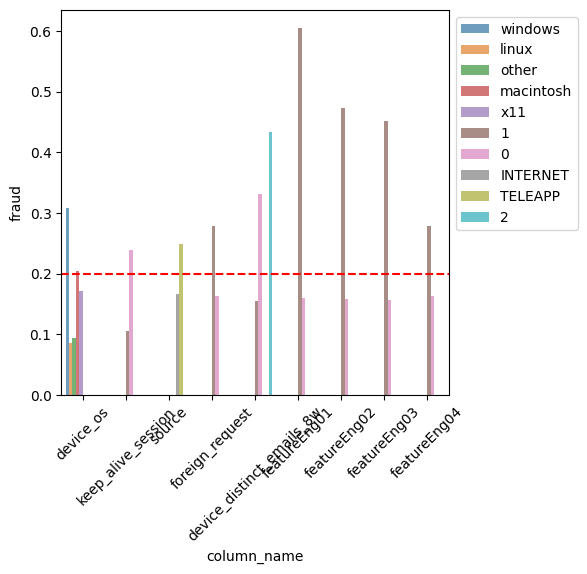

In [16]:
# reprint fraud proportion
# caluclate proportion of fraud vs non-fraud for each category
# for each column, calculate the proportion of fraud vs non-fraud, store in dataframe
# there are 4 columns, 'column_name', 'category', 'fraud', 'non_fraud'
fraud_proportion = pd.DataFrame(columns=['column_name', 'category', 'fraud', 'non_fraud'])
for col in device_activity_df_cat.columns[1:]:
    for cat in device_activity_df_cat[col].unique():
        fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 1)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])
        non_fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 0)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])

        # add to dataframe using pd.concat to row
        fraud_proportion = pd.concat([fraud_proportion, pd.DataFrame({'column_name': [col], 'category': [cat], 'fraud': [fraud], 'non_fraud': [non_fraud]})])

# print table
print(fraud_proportion)

# a stacked barplot the proportion of fraud vs non-fraud for each category
# each column is labeled column_name + _ + category
# fraud is in red, non-fraud is in blue
# the y-axis is the proportion
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.barplot(data=fraud_proportion, x='column_name', y='fraud', hue='category', alpha=0.7)
plt.axhline(y=0.2, color='r', linestyle='--')
plt.xticks(rotation=45)
# legend is outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

### Feature 5: `source` == INTERNET & `device_os` == windows, featureEng05 = 1, else 0

<Axes: xlabel='featureEng05', ylabel='count'>

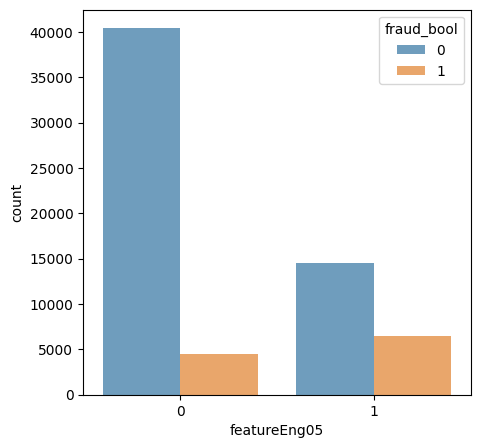

In [17]:
# label columns with the following conditions met as a new column, 'featureEng02'
# if conditions met, label as 1, else 0
# 1. device_distinct_emails_8w is 2
# 2. keep_alive_session is '0'
device_activity_df_cat['featureEng05'] = 0
device_activity_df_cat.loc[(device_activity_df_cat['source'] == 'INTERNET') & (device_activity_df_cat['device_os'] == 'windows'), 'featureEng05'] = 1

# change 'featureEng02' to category
device_activity_df_cat['featureEng05'] = device_activity_df_cat['featureEng05'].astype('category')

# plot the proportion of fraud vs non-fraud for the new column 'featureEng01'
# fraud is in red, non-fraud is in blue
# y axis is the count
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.countplot(data=device_activity_df_cat, x='featureEng05', hue='fraud_bool', alpha=0.7)

                 column_name   category     fraud  non_fraud
0                  device_os    windows  0.308299   0.691701
0                  device_os      linux  0.085653   0.914347
0                  device_os      other  0.094239   0.905761
0                  device_os  macintosh  0.204076   0.795924
0                  device_os        x11  0.171247   0.828753
0         keep_alive_session          1  0.105193   0.894807
0         keep_alive_session          0  0.239448   0.760552
0                     source   INTERNET  0.166179   0.833821
0                     source    TELEAPP  0.248718   0.751282
0            foreign_request          0  0.163176   0.836824
0            foreign_request          1  0.278894   0.721106
0  device_distinct_emails_8w          1  0.155487   0.844513
0  device_distinct_emails_8w          2  0.433417   0.566583
0  device_distinct_emails_8w          0  0.331742   0.668258
0               featureEng01          0  0.158957   0.841043
0               featureE

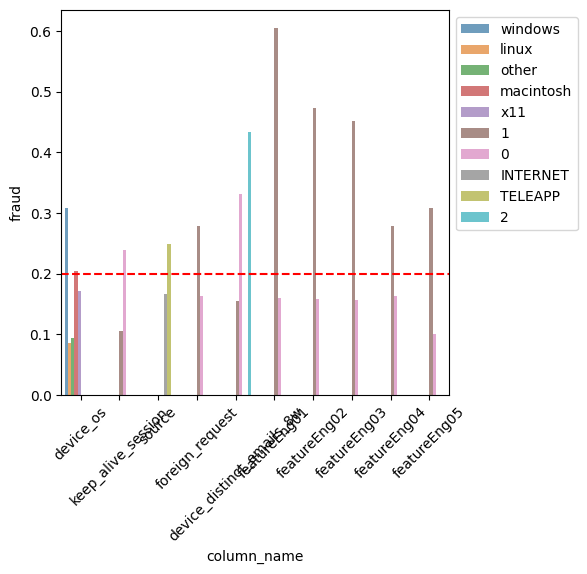

In [18]:
# reprint fraud proportion
# caluclate proportion of fraud vs non-fraud for each category
# for each column, calculate the proportion of fraud vs non-fraud, store in dataframe
# there are 4 columns, 'column_name', 'category', 'fraud', 'non_fraud'
fraud_proportion = pd.DataFrame(columns=['column_name', 'category', 'fraud', 'non_fraud'])
for col in device_activity_df_cat.columns[1:]:
    for cat in device_activity_df_cat[col].unique():
        fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 1)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])
        non_fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 0)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])

        # add to dataframe using pd.concat to row
        fraud_proportion = pd.concat([fraud_proportion, pd.DataFrame({'column_name': [col], 'category': [cat], 'fraud': [fraud], 'non_fraud': [non_fraud]})])

# print table
print(fraud_proportion)

# a stacked barplot the proportion of fraud vs non-fraud for each category
# each column is labeled column_name + _ + category
# fraud is in red, non-fraud is in blue
# the y-axis is the proportion
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.barplot(data=fraud_proportion, x='column_name', y='fraud', hue='category', alpha=0.7)
plt.axhline(y=0.2, color='r', linestyle='--')
plt.xticks(rotation=45)
# legend is outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

### Summary of Feature Engineering

In [ ]:
# feature01: device_os is 'windows' and device_distinct_emails_8w is 0 or 2
# feature02: device_distinct_emails_8w is 2 or keep_alive_session is '0'
# feature03: device_distinct_emails_8w is 0 or 2 or keep_alive_session is '0'
# feature04: foreign_request is 1 and source is 'INTERNET'
# feature05: source is 'INTERNET' and device_os is 'windows'

In [7]:
device_activity_df['fraud_bool'].value_counts().to_frame().loc[1, "count"]

10995

In [8]:
total_fraud_count = device_activity_df['fraud_bool'].value_counts().to_frame().loc[1, "count"]
total_non_fraud_count = device_activity_df['fraud_bool'].value_counts().to_frame().loc[1, "count"]

# print total counts of fraud and non-fraud
print(f"Total Fraud Count: {total_fraud_count}")
print(f"Total Non-Fraud Count: {total_non_fraud_count}")
print(f"Total Count: {total_fraud_count + total_non_fraud_count} \t Data Shape: {device_activity_df.shape}")

Total Fraud Count: 10995
Total Non-Fraud Count: 10995
Total Count: 21990 	 Data Shape: (65970, 7)


In [9]:
print(f'device_activity_df shape: {device_activity_df.shape}')
device_activity_df.head()

device_activity_df shape: (65970, 7)


fraud_bool  session_length_in_minutes device_os  keep_alive_session  \
43           1                   4.036394   windows                   1   
140          1                  12.928072   windows                   0   
284          1                   2.550167     linux                   0   
314          1                   3.500856   windows                   0   
561          1                  44.536211   windows                   0   

    device_distinct_emails_8w    source  foreign_request  
43                          1  INTERNET                0  
140                         1  INTERNET                0  
284                         1  INTERNET                0  
314                         1  INTERNET                0  
561                         1  INTERNET                0

In [10]:
device_activity_df.dtypes

fraud_bool                   category
session_length_in_minutes     float64
device_os                    category
keep_alive_session              int64
device_distinct_emails_8w    category
source                       category
foreign_request                 uint8
dtype: object

In [23]:
def getFraudInfo(group):
    # get total count of fraud within this group
    fraud_count = group['fraud_bool'].value_counts().to_frame().loc[1, "count"]
    total_count = group.shape[0]
    fraud_proportion = round(fraud_count / total_count, 4)

    group['num_fraud'] = fraud_count
    group['proportion_of_fraud_in_group'] = fraud_proportion
    return group[['num_fraud', 'proportion_of_fraud_in_group']].drop_duplicates()

## Feature 1

* Group 'device_os', 'device_distinct_emails_8w' into 5 groups, assign relevant proababilites to each group

In [24]:
# feature01: device_os is 'windows' and device_distinct_emails_8w is 0 or 2
device_activity_df.groupby(['device_os', 'device_distinct_emails_8w']).apply(getFraudInfo).reset_index()

device_os device_distinct_emails_8w  level_2  num_fraud  \
0       linux                         0    87839          9   
1       linux                         1      284       1546   
2       linux                         2     7307        156   
3   macintosh                         0    83650         12   
4   macintosh                         1     3150        674   
5   macintosh                         2     2065         65   
6       other                         0    15214         63   
7       other                         1     1139       1726   
8       other                         2     4511        169   
9     windows                         0     5351         53   
10    windows                         1       43       5804   
11    windows                         2      728        637   
12        x11                         0   347903          2   
13        x11                         1    10801         71   
14        x11                         2   158126          8   

    proportion_of_fraud_in_group  
0                         0.1385  
1                         0.0802  
2                         0.2492  
3                         0.4800  
4                         0.1920  
5                         0.4483  
6                         0.2775  
7                         0.0863  
8                         0.3062  
9                         0.5408  
10                        0.2913  
11                        0.6107  
12                        0.5000  
13                        0.1588  
14                        0.3636

(0.0, 6000.0)

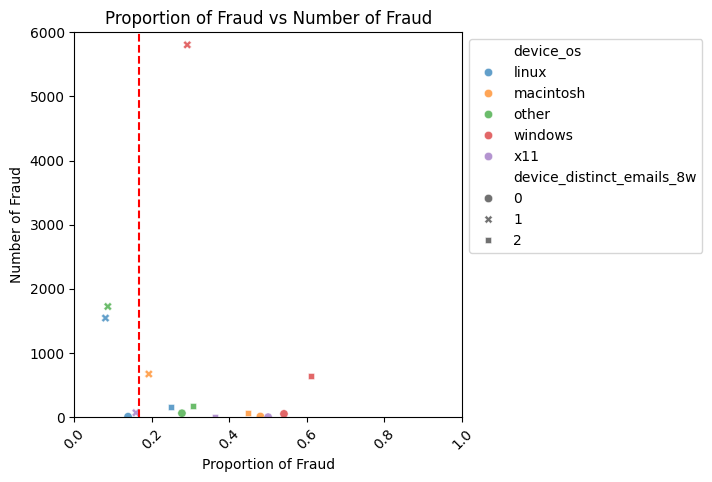

In [28]:
# plot a scatter plot, x-axis: proportion of fraud, y-axis: number of fraud
# plot a vertical line at x = 1/6, make title, x-axis label, y-axis label, and legend, x-axis tilt by 45 degrees
# color code by device_os and device_distinct_emails_8w, for example, device_os = 'windows' and device_distinct_emails_8w = 0 is red, etc..
# axes must start from 0
plt.figure(figsize=(5, 5))
sns.scatterplot(data=device_activity_df.groupby(['device_os', 'device_distinct_emails_8w']).apply(getFraudInfo).reset_index(), x='proportion_of_fraud_in_group', y='num_fraud', hue='device_os', style='device_distinct_emails_8w', alpha=0.7)
plt.axvline(x=1/6, color='r', linestyle='--')
plt.title('Proportion of Fraud vs Number of Fraud')
plt.xlabel('Proportion of Fraud')
plt.ylabel('Number of Fraud')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlim(0, 1)
plt.ylim(0, 6000)


In [29]:
# 5 groups for feature 1
# group01 = filter for conditions where device_os == windows and device_distinct_emails_8w.isin([0,2])
# group02 = filter for conditions where device_os == macintosh and device_distinct_emails_8w.isin([0,2])
# group03 = filter for conditions where device_os == x11 and device_distinct_emails_8w.isin([0,2])
# group04 = filter for conditions where device_os == other and device_distinct_emails_8w.isin([0,2])
# group05 = everything else

# split device_activity_df into 5 groups by these conditions
group01 = device_activity_df[(device_activity_df['device_os'] == 'windows') & (device_activity_df['device_distinct_emails_8w'].isin([0, 2]))]
group02 = device_activity_df[(device_activity_df['device_os'] == 'macintosh') & (device_activity_df['device_distinct_emails_8w'].isin([0, 2]))]
group03 = device_activity_df[(device_activity_df['device_os'] == 'x11') & (device_activity_df['device_distinct_emails_8w'].isin([0, 2]))]
group04 = device_activity_df[(device_activity_df['device_os'] == 'other') & (device_activity_df['device_distinct_emails_8w'].isin([0, 2]))]
# group05 will be all the groups except those in group01, group02, group03, group04
group05 = device_activity_df[~device_activity_df.index.isin(group01.index) & ~device_activity_df.index.isin(group02.index) & ~device_activity_df.index.isin(group03.index) & ~device_activity_df.index.isin(group04.index)]

# combine into 1 dataframe, add label to that dataframe, label each group 'A', 'B', 'C', 'D', 'E', all in new column 'FE_01'
group01['FE_01'] = 'A'; group02['FE_01'] = 'B'; group03['FE_01'] = 'C'; group04['FE_01'] = 'D'; group05['FE_01'] = 'E'
device_activity_df = pd.concat([group01, group02, group03, group04, group05])

# change 'FE_01' to category
device_activity_df['FE_01'] = device_activity_df['FE_01'].astype('category')

# check shape print head
print(f'device_activity_df shape: {device_activity_df.shape}')
device_activity_df.head()

device_activity_df shape: (65970, 8)


/var/folders/_3/8z9s_23x6w349w1_9vlqlhzh0000gn/T/ipykernel_44844/3192673354.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group01['FE_01'] = 'A'; group02['FE_01'] = 'B'; group03['FE_01'] = 'C'; group04['FE_01'] = 'D'; group05['FE_01'] = 'E'


fraud_bool  session_length_in_minutes device_os  keep_alive_session  \
728           1                  11.148815   windows                   1   
4666          1                  35.188807   windows                   0   
5351          1                   6.318178   windows                   0   
5394          1                  10.127331   windows                   0   
5856          1                   7.989567   windows                   0   

     device_distinct_emails_8w    source  foreign_request FE_01  
728                          2  INTERNET                0     A  
4666                         2  INTERNET                0     A  
5351                         0  INTERNET                0     A  
5394                         2  INTERNET                0     A  
5856                         2  INTERNET                0     A

In [30]:
device_activity_df.groupby(['FE_01']).apply(getFraudInfo).reset_index()

FE_01  level_1  num_fraud  proportion_of_fraud_in_group
0     A      728        690                        0.6047
1     B     2065         77                        0.4529
2     C   158126         10                        0.3846
3     D     4511        232                        0.2978
4     E       43       9986                        0.1564

In [31]:
# assign proability of fraud based on label, so if device_activity_df['FE_01'] labelled 'A', then assign corresponding probability of fraud
FE_01_prob = device_activity_df.groupby(['FE_01']).apply(getFraudInfo).reset_index()[['FE_01', 'proportion_of_fraud_in_group']]

FE_01_prob_mapping = {"A": 0.6047,
                      "B": 0.4529,
                      "C": 0.3846,
                      "D": 0.2978,
                      "E": 0.1564}

# map the probability of fraud to the device_acitivtiy_df, as a new column 'FE_01_device_os_emails_prob'
device_activity_df['FE_01_device_os_emails_prob'] = device_activity_df['FE_01'].map(FE_01_prob_mapping)

# check shape and head
print(f'device_activity_df shape: {device_activity_df.shape}')
device_activity_df.head()


device_activity_df shape: (65970, 9)


fraud_bool  session_length_in_minutes device_os  keep_alive_session  \
728           1                  11.148815   windows                   1   
4666          1                  35.188807   windows                   0   
5351          1                   6.318178   windows                   0   
5394          1                  10.127331   windows                   0   
5856          1                   7.989567   windows                   0   

     device_distinct_emails_8w    source  foreign_request FE_01  \
728                          2  INTERNET                0     A   
4666                         2  INTERNET                0     A   
5351                         0  INTERNET                0     A   
5394                         2  INTERNET                0     A   
5856                         2  INTERNET                0     A   

     FE_01_device_os_emails_prob  
728                       0.6047  
4666                      0.6047  
5351                      0.6047  
5394                      0.6047  
5856                      0.6047

## Feature 2

* Group 'keep_alive_session' and 'device_distinct_emails', assign relevant probabilities

In [32]:
# feature02: keep alive session is 0 and device_distinct_emails_8w is 0 or 2
device_activity_df.groupby(['keep_alive_session', 'device_distinct_emails_8w']).apply(getFraudInfo).reset_index()

keep_alive_session device_distinct_emails_8w  level_2  num_fraud  \
0                   0                         0     5351        132   
1                   0                         1      140       6252   
2                   0                         2     4666        849   
3                   1                         0   942751          7   
4                   1                         1       43       3569   
5                   1                         2      728        186   

   proportion_of_fraud_in_group  
0                        0.3520  
1                        0.2230  
2                        0.4732  
3                        0.1591  
4                        0.1016  
5                        0.3131

(0.0, 4000.0)

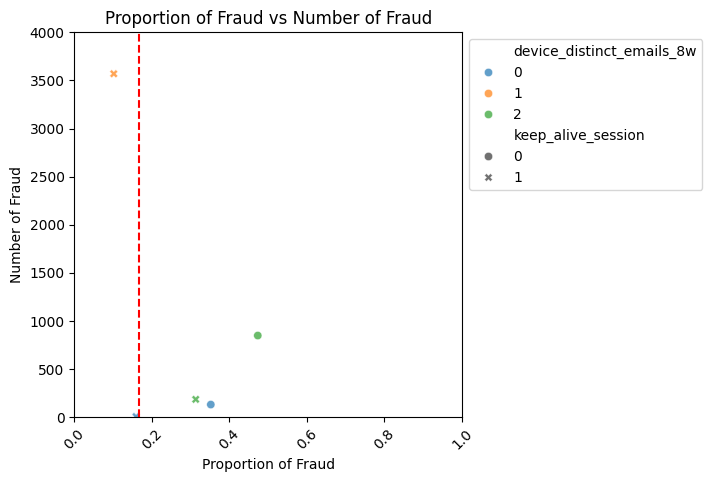

In [36]:
# plot a scatter plot, x-axis: proportion of fraud, y-axis: number of fraud
# plot a vertical line at x = 1/6, make title, x-axis label, y-axis label, and legend, x-axis tilt by 45 degrees
# color code by device_os and device_distinct_emails_8w, for example, device_os = 'windows' and device_distinct_emails_8w = 0 is red, etc..
# axes must start from 0
plt.figure(figsize=(5, 5))
sns.scatterplot(data=device_activity_df.groupby(['keep_alive_session', 'device_distinct_emails_8w']).apply(getFraudInfo).reset_index(), x='proportion_of_fraud_in_group', y='num_fraud', hue='device_distinct_emails_8w', style='keep_alive_session', alpha=0.7)
plt.axvline(x=1/6, color='r', linestyle='--')
plt.title('Proportion of Fraud vs Number of Fraud')
plt.xlabel('Proportion of Fraud')
plt.ylabel('Number of Fraud')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlim(0, 1)
plt.ylim(0, 4000)


In [37]:
# divide into 6 groups, one for each unique permutation of keep_alive_session and device_distinct_emails_8w
group01 = device_activity_df[(device_activity_df['keep_alive_session'] == 0) & (device_activity_df['device_distinct_emails_8w'] == 0)]
group02 = device_activity_df[(device_activity_df['keep_alive_session'] == 0) & (device_activity_df['device_distinct_emails_8w'] == 1)]
group03 = device_activity_df[(device_activity_df['keep_alive_session'] == 0) & (device_activity_df['device_distinct_emails_8w'] == 2)]
group04 = device_activity_df[(device_activity_df['keep_alive_session'] == 1) & (device_activity_df['device_distinct_emails_8w'] == 0)]
group05 = device_activity_df[(device_activity_df['keep_alive_session'] == 1) & (device_activity_df['device_distinct_emails_8w'] == 1)]
group06 = device_activity_df[(device_activity_df['keep_alive_session'] == 1) & (device_activity_df['device_distinct_emails_8w'] == 2)]

# label each group from "A" to "F"
group01['FE_02'] = "A"; group02['FE_02'] = "B"; group03['FE_02'] = "C"; group04['FE_02'] = "D"; group05['FE_02'] = "E"; group06['FE_02'] = "F"

# concatenate all the group
device_activity_df = pd.concat([group01, group02, group03, group04, group05, group06])

# change 'FE_02' to category
device_activity_df['FE_02'] = device_activity_df['FE_02'].astype('category')

# generate mapping
FE_02_prob_mappping = {"A": 0.3520,
                       "B": 0.2230,
                       "C": 0.4732,
                       "D": 0.1591,
                       "E": 0.1016,
                       "F": 0.3131
                       }

# map the probability of fraud to the device_acitivtiy_df, as a new column 'FE_01_device_os_emails_prob'
device_activity_df['FE_02_keep_alive_device_emails_prob'] = device_activity_df['FE_02'].map(FE_02_prob_mappping)

# check shape and head
print(f'device_activity_df shape: {device_activity_df.shape}')
device_activity_df.head()

device_activity_df shape: (65970, 11)


/var/folders/_3/8z9s_23x6w349w1_9vlqlhzh0000gn/T/ipykernel_44844/286088569.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group01['FE_02'] = "A"; group02['FE_02'] = "B"; group03['FE_02'] = "C"; group04['FE_02'] = "D"; group05['FE_02'] = "E"; group06['FE_02'] = "F"
/var/folders/_3/8z9s_23x6w349w1_9vlqlhzh0000gn/T/ipykernel_44844/286088569.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group01['FE_02'] = "A"; group02['FE_02'] = "B"; group03['FE_02'] = "C"; group04['FE_02'] = "D"; group05['FE_02'] 

fraud_bool  session_length_in_minutes device_os  keep_alive_session  \
5351           1                   6.318178   windows                   0   
11515          1                   2.479942   windows                   0   
23349          1                   2.919222   windows                   0   
44832          1                   4.589128   windows                   0   
92505          1                  38.778095   windows                   0   

      device_distinct_emails_8w    source  foreign_request FE_01  \
5351                          0  INTERNET                0     A   
11515                         0  INTERNET                1     A   
23349                         0  INTERNET                0     A   
44832                         0  INTERNET                0     A   
92505                         0  INTERNET                0     A   

      FE_01_device_os_emails_prob FE_02 FE_02_keep_alive_device_emails_prob  
5351                       0.6047     A                               0.352  
11515                      0.6047     A                               0.352  
23349                      0.6047     A                               0.352  
44832                      0.6047     A                               0.352  
92505                      0.6047     A                               0.352

## Feature 3

* Group 'foreign_request' and 'source', assign relevant probabilites

In [43]:
# feature03: foreign request is 1 and source == internet
device_activity_df.groupby(['source', 'foreign_request']).apply(getFraudInfo).reset_index()

source  foreign_request  level_2  num_fraud  proportion_of_fraud_in_group
0  INTERNET                0     5351      10346                        0.1627
1  INTERNET                1    11515        552                        0.2782
2   TELEAPP                0   199588         94                        0.2448
3   TELEAPP                1   647497          3                        0.5000

In [45]:
# divide into 4 groups, one for each unique permutation of foreign_request and source
group01 = device_activity_df[(device_activity_df['source'] == "INTERNET") & (device_activity_df['foreign_request'] == 0)]
group02 = device_activity_df[(device_activity_df['source'] == "INTERNET") & (device_activity_df['foreign_request'] == 1)]
group04 = device_activity_df[(device_activity_df['source'] == "TELEAPP") & (device_activity_df['foreign_request'] == 0)]
group03 = device_activity_df[(device_activity_df['source'] == "TELEAPP") & (device_activity_df['foreign_request'] == 1)]

# label each group from "A" to "D", label_name = "FE_03"
group01['FE_03'] = "A"; group02['FE_03'] = "B"; group03['FE_03'] = "C"; group04['FE_03'] = "D"


# concatenate all the group
device_activity_df = pd.concat([group01, group02, group03, group04])

# change 'FE_02' to category
device_activity_df['FE_03'] = device_activity_df['FE_03'].astype('category')

# generate mapping
FE_03_prob_mappping = {"A": 0.1627,
                       "B": 0.2782,
                       "C": 0.2448,
                       "D": 0.5000
                       }

# map the probability of fraud to the device_acitivtiy_df, as a new column 'FE_01_device_os_emails_prob'
device_activity_df['FE_03_source_foreign_request_prob'] = device_activity_df['FE_03'].map(FE_02_prob_mappping)

# check shape and head
print(f'device_activity_df shape: {device_activity_df.shape}')
device_activity_df.head()

device_activity_df shape: (65970, 14)


/var/folders/_3/8z9s_23x6w349w1_9vlqlhzh0000gn/T/ipykernel_44844/475886292.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group01['FE_03'] = "A"; group02['FE_03'] = "B"; group03['FE_03'] = "C"; group04['FE_03'] = "D"


fraud_bool  session_length_in_minutes device_os  keep_alive_session  \
5351            1                   6.318178   windows                   0   
23349           1                   2.919222   windows                   0   
44832           1                   4.589128   windows                   0   
92505           1                  38.778095   windows                   0   
111006          1                   5.060280   windows                   0   

       device_distinct_emails_8w    source  foreign_request FE_01  \
5351                           0  INTERNET                0     A   
23349                          0  INTERNET                0     A   
44832                          0  INTERNET                0     A   
92505                          0  INTERNET                0     A   
111006                         0  INTERNET                0     A   

       FE_01_device_os_emails_prob FE_02 FE_02_keep_alive_device_emails_prob  \
5351                        0.6047     A                               0.352   
23349                       0.6047     A                               0.352   
44832                       0.6047     A                               0.352   
92505                       0.6047     A                               0.352   
111006                      0.6047     A                               0.352   

       FE_03 FE_03_source_foreign_request FE_03_source_foreign_request_prob  
5351       A                        0.352                             0.352  
23349      A                        0.352                             0.352  
44832      A                        0.352                             0.352  
92505      A                        0.352                             0.352  
111006     A                        0.352                             0.352

## Feature 4

* Group by source and device os

In [46]:
# feature04: foreign request is 1 and device_os == windows
device_activity_df.groupby(['device_os', 'foreign_request']).apply(getFraudInfo).reset_index()

device_os  foreign_request  level_2  num_fraud  \
0      linux                0    87839       1592   
1      linux                1   855358        119   
2  macintosh                0   111064        712   
3  macintosh                1    96637         39   
4      other                0    15214       1909   
5      other                1   137953         49   
6    windows                0     5351       6150   
7    windows                1    11515        344   
8        x11                0   347903         77   
9        x11                1   226270          4   

   proportion_of_fraud_in_group  
0                        0.0829  
1                        0.1549  
2                        0.2010  
3                        0.2826  
4                        0.0933  
5                        0.1546  
6                        0.3027  
7                        0.4605  
8                        0.1700  
9                        0.2000

(0.0, 1.0)

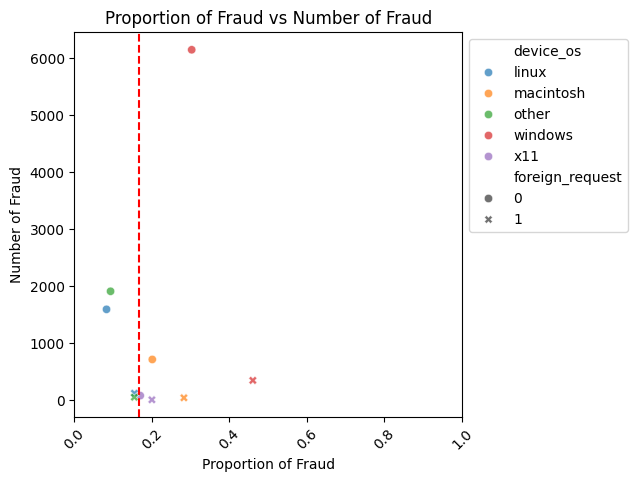

In [48]:
# plot a scatter plot, x-axis: proportion of fraud, y-axis: number of fraud
# plot a vertical line at x = 1/6, make title, x-axis label, y-axis label, and legend, x-axis tilt by 45 degrees
# color code by device_os and device_distinct_emails_8w, for example, device_os = 'windows' and device_distinct_emails_8w = 0 is red, etc..
# axes must start from 0
plt.figure(figsize=(5, 5))
sns.scatterplot(data=device_activity_df.groupby(['foreign_request', 'device_os']).apply(getFraudInfo).reset_index(), x='proportion_of_fraud_in_group', y='num_fraud', hue='device_os', style='foreign_request', alpha=0.7)
plt.axvline(x=1/6, color='r', linestyle='--')
plt.title('Proportion of Fraud vs Number of Fraud')
plt.xlabel('Proportion of Fraud')
plt.ylabel('Number of Fraud')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlim(0, 1)


In [51]:
# group into 4 groups
# divide into 4 groups, one for each unique permutation of foreign_request and source
group01 = device_activity_df[(device_activity_df['device_os'] == "windows") & (device_activity_df['foreign_request'] == 0)]
group02 = device_activity_df[(device_activity_df['device_os'] == "windows") & (device_activity_df['foreign_request'] == 1)]
group03 = device_activity_df[(device_activity_df['device_os'] == "macintosh") & (device_activity_df['foreign_request'] == 0)]
group04 = device_activity_df[~device_activity_df.index.isin(group01.index) & ~device_activity_df.index.isin(group02.index) & ~device_activity_df.index.isin(group03.index)]

# label each group from "A" to "D", label_name = "FE_03"
group01['FE_04'] = "A"; group02['FE_04'] = "B"; group03['FE_04'] = "C"; group04['FE_04'] = "D"


# concatenate all the group
device_activity_df = pd.concat([group01, group02, group03, group04])

# change 'FE_04' to category
device_activity_df['FE_04'] = device_activity_df['FE_04'].astype('category')

device_activity_df.groupby(['FE_04']).apply(getFraudInfo).reset_index()

/var/folders/_3/8z9s_23x6w349w1_9vlqlhzh0000gn/T/ipykernel_44844/307728495.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group01['FE_04'] = "A"; group02['FE_04'] = "B"; group03['FE_04'] = "C"; group04['FE_04'] = "D"


FE_04  level_1  num_fraud  proportion_of_fraud_in_group
0     A     5351       6150                        0.3027
1     B    11515        344                        0.4605
2     C   111064        712                        0.2010
3     D   347903       3789                        0.0916

In [52]:
# generate mapping
FE_04_prob_mappping = {"A": 0.3027,
                       "B": 0.4605,
                       "C": 0.2010,
                       "D": 0.0916
                       }

# map the probability of fraud to the device_acitivtiy_df, as a new column 'FE_01_device_os_emails_prob'
device_activity_df['FE_04_device_os_foreign_request'] = device_activity_df['FE_04'].map(FE_04_prob_mappping)

# check shape and head
print(f'device_activity_df shape: {device_activity_df.shape}')
device_activity_df.head()

device_activity_df shape: (65970, 16)


fraud_bool  session_length_in_minutes device_os  keep_alive_session  \
5351            1                   6.318178   windows                   0   
23349           1                   2.919222   windows                   0   
44832           1                   4.589128   windows                   0   
92505           1                  38.778095   windows                   0   
111006          1                   5.060280   windows                   0   

       device_distinct_emails_8w    source  foreign_request FE_01  \
5351                           0  INTERNET                0     A   
23349                          0  INTERNET                0     A   
44832                          0  INTERNET                0     A   
92505                          0  INTERNET                0     A   
111006                         0  INTERNET                0     A   

       FE_01_device_os_emails_prob FE_02 FE_02_keep_alive_device_emails_prob  \
5351                        0.6047     A                               0.352   
23349                       0.6047     A                               0.352   
44832                       0.6047     A                               0.352   
92505                       0.6047     A                               0.352   
111006                      0.6047     A                               0.352   

       FE_03 FE_03_source_foreign_request FE_03_source_foreign_request_prob  \
5351       A                        0.352                             0.352   
23349      A                        0.352                             0.352   
44832      A                        0.352                             0.352   
92505      A                        0.352                             0.352   
111006     A                        0.352                             0.352   

       FE_04 FE_04_device_os_foreign_request  
5351       A                          0.3027  
23349      A                          0.3027  
44832      A                          0.3027  
92505      A                          0.3027  
111006     A                          0.3027

## Feature 5

* Assign probabilities to device_os instead of categories

In [53]:
# feature05: foreign request is 1 and device_os == windows
device_activity_df.groupby(['device_os']).apply(getFraudInfo).reset_index()

device_os  level_1  num_fraud  proportion_of_fraud_in_group
0      linux    87839       1711                        0.0857
1  macintosh   111064        751                        0.2041
2      other    15214       1958                        0.0942
3    windows     5351       6494                        0.3083
4        x11   347903         81                        0.1712

In [54]:
# assign mapp probability
# generate mapping
FE_05_prob_mappping = {"windows": 0.3083,
                       "macintosh": 0.2041,
                       "linux": 0.0001,
                       "other": 0.0001,
                       "x11": 0.0001
                       }

# map the probability of fraud to the device_acitivtiy_df, as a new column 'FE_01_device_os_emails_prob'
device_activity_df['FE_05_device_os'] = device_activity_df['device_os'].map(FE_05_prob_mappping)

# check shape and head
print(f'device_activity_df shape: {device_activity_df.shape}')
device_activity_df.head()

device_activity_df shape: (65970, 17)


fraud_bool  session_length_in_minutes device_os  keep_alive_session  \
5351            1                   6.318178   windows                   0   
23349           1                   2.919222   windows                   0   
44832           1                   4.589128   windows                   0   
92505           1                  38.778095   windows                   0   
111006          1                   5.060280   windows                   0   

       device_distinct_emails_8w    source  foreign_request FE_01  \
5351                           0  INTERNET                0     A   
23349                          0  INTERNET                0     A   
44832                          0  INTERNET                0     A   
92505                          0  INTERNET                0     A   
111006                         0  INTERNET                0     A   

       FE_01_device_os_emails_prob FE_02 FE_02_keep_alive_device_emails_prob  \
5351                        0.6047     A                               0.352   
23349                       0.6047     A                               0.352   
44832                       0.6047     A                               0.352   
92505                       0.6047     A                               0.352   
111006                      0.6047     A                               0.352   

       FE_03 FE_03_source_foreign_request FE_03_source_foreign_request_prob  \
5351       A                        0.352                             0.352   
23349      A                        0.352                             0.352   
44832      A                        0.352                             0.352   
92505      A                        0.352                             0.352   
111006     A                        0.352                             0.352   

       FE_04 FE_04_device_os_foreign_request  FE_05_device_os  
5351       A                          0.3027           0.3083  
23349      A                          0.3027           0.3083  
44832      A                          0.3027           0.3083  
92505      A                          0.3027           0.3083  
111006     A                          0.3027           0.3083

# FE steps only

In [ ]:
# read data
